---
title: RMS to interval velocity figures
description: ''
short_title: ''
date: '2024-01-03T01:37:27.992Z'
name: rms-to-interval-velocity-figures
venue: Notebooks
oxa: oxa:VNMrkxzChhdveZyf6lmb/5SESxN02BJ9UmOB05xNM
tags: []
keywords: []
---

# RMS to Interval Velocity

Goals: Illustrate the non-uniqueness in the inverse problem that arises because we have only a finite number of data and the data are contaminated with errors. 
 
In the following sections we:

    Compute the Vrms velocity from an interval velocity vint
    Use an analytic formula to invert Vrms and recover vint
    Forward model: compute Vrms using an analytic function.
    Invert with a finite set of accurate data
    Invert with a finite set of inaccurate data
    

In [ ]:
from ipywidgets import interact, FloatSlider, ToggleButtons, IntSlider, FloatText, IntText, Checkbox, RadioButtons
from scipy.interpolate import interp1d
import numpy as np
from matplotlib import pyplot as plt
# import matplotlib as mpl
from scipy.integrate import quad

## Basic Functions 

In [ ]:
def compute_vint_analytic(v0, a, T, dt, tmax):
    """
    Compute the interval velocity at all times
    v0: global amplitude constant
    a: relative amplitude of sinusoid
    T: oscillation period in seconds
    dt: sampling interval
    tmax: maximum time
    """
    
    t = np.arange(0., tmax+0.001*dt, dt)
    
    return v0*(1 + a*np.sin(2.*np.pi*t/T))


def compute_vrms_analytic(v0, a, T, dt, tmax):
    """
    Compute the RMS velocity
    v0: global amplitude constant
    a: relative amplitude of sinusoid
    T: oscillation period in seconds
    dt: sampling interval
    tmax: maximum time
    """
    
    t = np.arange(dt, tmax+0.001*dt, dt)
    
    w = 2.*np.pi/T
    vrms = (1. + a**2/2.) + 2.*a*(1 - np.cos(w*t) - a*np.sin(2*w*t)/8.)/(w*t)
    return np.r_[v0, v0*np.sqrt(vrms)]




### Forward Problem:  Generate $v_{int}$ and Vrms

The interval velocity and RMS velocity are considered to be functions. A digital approximation can be obtained by sampling the true functions at a large number of equally spaced nodes. 


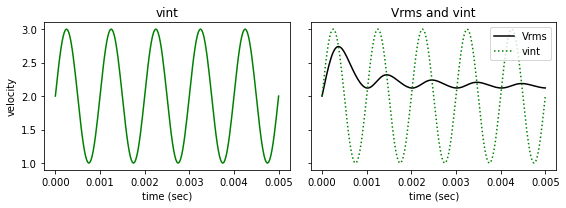

In [ ]:
n_nodes = 201           # functions will be evaluated on the nodes.
n_cells = n_nodes - 1   # Number of cells  

# Set the parameters for the 
v0 = 2.0
a = 0.5
T = .001  #fundamental period
tmax = .005 #interval (0,tmax)
dt = tmax/n_cells
t = np.linspace(0, tmax, n_nodes)


# Generate the interval velocity
vint = compute_vint_analytic(v0, a, T, dt, tmax)

#compute RMS velocity using analytic formulae
vrms = compute_vrms_analytic(v0, a, T, dt, tmax)

fig, ax = plt.subplots(1,2, figsize=(8, 3), sharey=True)
ax[0].plot(t, vint, '-g')
ax[0].set_title('vint')
ax[0].set_xlabel('time (sec)')
ax[0].set_ylabel('velocity')


ax[1].plot(t, vrms, '-k', label='Vrms')
ax[1].plot(t, vint, ':g', label='vint')
ax[1].set_xlabel('time (sec)')
ax[1].set_title('Vrms and vint')
plt.legend()

plt.tight_layout()

In [ ]:
len(vint)

201

###  Invert Vrms to obtain v_int

In [ ]:
def compute_vint_inverted(t, vrms):
    """
    Invert to recover interval velocity.
    t: times (s) (t[0] is assumed to be zero)
    vrms: RMS velocities (m/s)
    *** the derivatives are applied at nodal locations; 
    """
    
    # Compute derivative using a foward difference
    
    dvdt_approx = np.diff(vrms)/np.diff(t)
    
    # Assign the derivatives to the nodes and set the derivative
    # at t=0 equal to zero
    
    dvdt_nodes = np.r_[0., dvdt_approx]
    
    # Return the approximated interval velocity at the sampled times
    vint = vrms * np.sqrt(np.abs(1 + 2*t*dvdt_nodes/vrms))
    
    return vint

## Inversion with Perfect Data

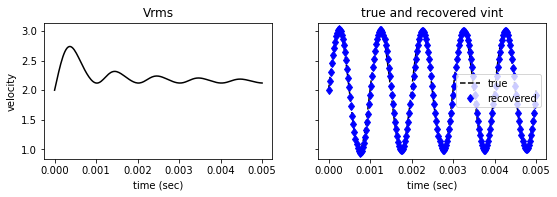

In [ ]:
vint_estimate = compute_vint_inverted(t, vrms)

fig2, ax = plt.subplots(1,2, figsize=(9,2.5), sharey=True)
ax[0].plot(t, vrms, '-k')
ax[0].set(title='Vrms',
         ylabel='velocity', xlabel='time (sec)')

ax[1].plot(t, vint, '--k', label='true')
ax[1].plot(t, vint_estimate, 'bd', label='recovered')
ax[1].set(title='true and recovered vint', xlabel='time (sec)' )
ax[1].legend()

## Inversion with finite number of accurate data

### Subsample, interpolate and invert
The observations are a sample of the true Vrms. Here we decimate the "function" by taking every "decimate" values
For each set of observations we interpolate them with different options (linear, cubic..) and then invert them using the analytic formula


In [ ]:
interp1d?

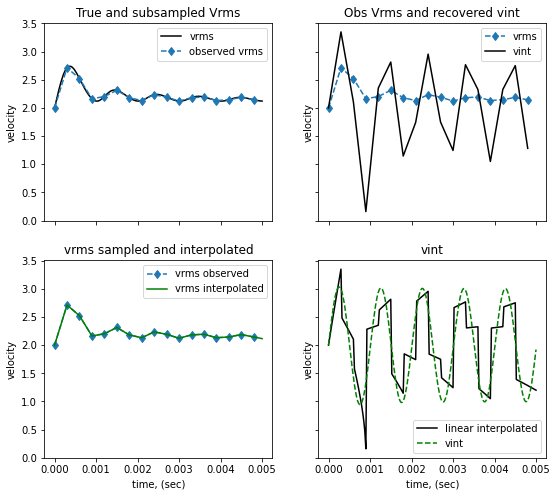

In [ ]:
# Given the initial sequence (t, vrms) subsample
# obtain times t_obs and vrms_obs
decimate = 12
t_obs = t[::decimate]
vrms_obs = vrms[::decimate]

#plot the true vrms and sampled observations
fig, ax=plt.subplots(2,2, figsize=(9,8), sharey=True, sharex=True)
ax[0,0].plot(t, vrms, '-k', label='vrms')
ax[0,0].plot(t_obs, vrms_obs, '--d', label='observed vrms')
ax[0,0].set(title='True and subsampled Vrms', ylabel='velocity')    
ax[0,0].legend()


vint_t = compute_vint_inverted(t, vrms)
vint_t_obs = compute_vint_inverted(t_obs, vrms_obs)

ax[0,1].plot(t_obs, vrms_obs, '--d', label='vrms')
ax[0,1].plot(t_obs, vint_t_obs, '-k', label='vint')
ax[0,1].set(title='Obs Vrms and recovered vint', ylabel='velocity')
ax[0,1].legend()

# interpolate the Vrms observations onto the initial node locations
f1 = interp1d(t_obs, vrms_obs, kind='cubic', fill_value='extrapolate')
# f1 = interp1d(t_obs, vrms_obs, kind='slinear', fill_value='extrapolate')
vrms_interpolated = f1(t)
vint_interpolated = compute_vint_inverted(t, vrms_interpolated)


ax[1,0].plot(t_obs, vrms_obs, '--d', label='vrms observed')
ax[1,0].plot(t, vrms_interpolated, '-g', label='vrms interpolated')
ax[1,0].set(title='vrms sampled and interpolated', ylabel='velocity', xlabel='time, (sec)')
ax[1,0].legend()

# ax[1,1].plot(t_obs, vint_t_obs, '--d', label='from obs')
ax[1,1].plot(t, vint_interpolated, '-k', label='cubic interpolated')
# ax[1,1].plot(t, vint_interpolated, '-k', label='linear interpolated')
ax[1,1].plot(t, vint_t, '--g', label='vint')
ax[1,1].set(title='vint', ylabel='velocity', xlabel='time, (sec)')
ax[1,1].legend()

## Inversion with a finite number of inaccurate data

### Add noise and interpolate

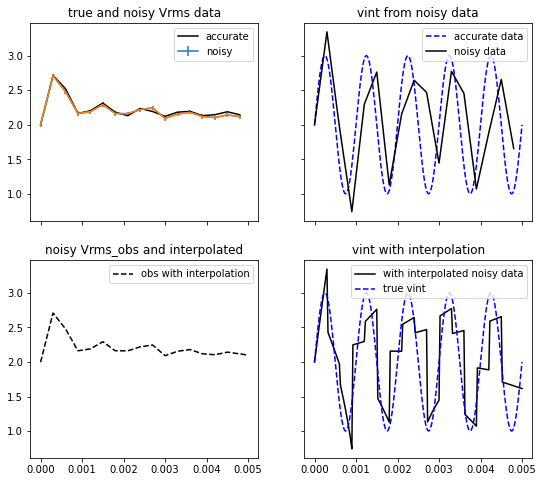

In [ ]:
mu = 0.
sigma = 0.03
noise = np.random.normal(mu, sigma, len(t_obs))
vrms_obs_noisy = vrms_obs + noise
yerr = sigma * np.ones(len(t_obs))


fig, ax = plt.subplots(2,2, figsize=(9,8), sharex=True, sharey=True)
ax[0,0].plot(t_obs, vrms_obs, '-k', label='accurate')
ax[0,0].errorbar(t_obs, vrms_obs_noisy, yerr=yerr, label='noisy')
ax[0,0].set_title('true and noisy Vrms data')
ax[0,0].legend()

# invert the noisy data directly and then with an interpolation
vint_t_obs_noisy = compute_vint_inverted(t_obs, vrms_obs_noisy)
f2 = interp1d(t_obs, vrms_obs_noisy, kind='slinear', fill_value='extrapolate')
vrms_interpolated_noisy = f2(t)
vint_interpolated_noisy = compute_vint_inverted(t, vrms_interpolated_noisy)


ax[0,1].plot(t, vint, '--b', label='accurate data')
ax[0,1].plot(t_obs, vint_t_obs_noisy, '-k', label='noisy data')
ax[0,1].set_title('vint from noisy data')
ax[0,1].legend()


# ax[1,0].plot(t_obs, vrms_obs, '-b', label='obs')
ax[1,0].errorbar(t_obs, vrms_obs_noisy, yerr=yerr, label='noisy')
ax[1,0].plot(t, vrms_interpolated_noisy, '--k', label='obs with interpolation')
ax[1,0].set_title('noisy Vrms_obs and interpolated')
ax[1,0].legend()


ax[1,1].plot(t, vint_interpolated_noisy, '-k', label='with interpolated noisy data')
ax[1,1].plot(t, vint, '--b', label='true vint')
ax[1,1].set_title('vint with interpolation')
ax[1,1].legend()


# RMS - Interval velocity problem

The RMS (Root Mean Square) velocity is related to the interval velocity through the equation XXX. This is a useful construct in reflection seismic data processing. Here we use this an an example to illustrate non-uniqueness and ill-conditioning that typifies inversion problems. For notation we use the symbol V to represent $V_{rms}$ and the symbol $v$ to represent $v_{int}$. The analytic expression XXX allows us to uniquely compute $v(t)$ from the function $V(t)$. To invert a finite number of observations $V(t_j) j=(1,N)$ we first interpolate these data and then use the analytic inversion formula. The results depend upon how the data are interpolated. The effects of noise on the data are examined in the same manner. Gaussian noise is added to each datum, the data are interpolated, and then the analytic inverse is applied.

# Forward Modelling


![](content/images/VNMrkxzChhdveZyf6lmb-FII6aSbAQhJjsXM8ZIQ8-v1.png)

# Inversion


![](block:VNMrkxzChhdveZyf6lmb/v6VG81hV4zMm9A7RnSB8/1)


![](block:VNMrkxzChhdveZyf6lmb/4Cb1zOw030e283zHusJb/1)

### Inversion with Infinite Amount of Accurate Data ✨

### Inversion with a Finite Number of Accurate Data 💯

### Inversion with a Finite Number of Inaccurate Data 🌎